# Linear Regression Exercises

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import scipy
from scipy import stats

What do I want people to do

* Load palmer penguins
* Run a linear regression on weight on just Adelie
* Use posterior predictive to understand how many penguins are above X grams
* Use two other features to predict penguin mass

* Expand regression to all species, just using bill length
  * How many beta parameters do we have now?
  * What is the slope of each

## Load Penguins Dataset

In [146]:
penguins = pd.read_csv("https://raw.githubusercontent.com/BayesianModelingandComputationInPython/BookCode_Edition1/main/data/penguins.csv")

In [147]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


### Set random seed

In [7]:
RANDOM_SEED = 8296
np.random.seed(RANDOM_SEED)

## Exercise 1: Intercept only regression
The Palmer Penguin dataset has been loaded for you. For the first exercise we want to focus just on the Adelie penguins.

1. Perform some exploratory data analysis to get a sense of the data
2. Write the model for an intercept only regression for body_mass_g
3. Sample from the prior predictive
4. Use MCMC sampling to estimate the model parameters
5. Using the arviz posterior plot, plot the posterior estimaets
   * What is the 75% HDI for these parameters
6. Plot the posterior predictive
  * How does it compare to the prior predictive?


In [148]:
adelie_mask = (penguins["species"] == "Adelie")
adelie_penguins = penguins[adelie_mask]

### Added back missing valules
the issue is PyMC still imputes it so it doesn't trap them as well as we'd hope

In [149]:
with pm.Model(rng_seeder=RANDOM_SEED) as penguin_simple:
    intercept = pm.Normal("intercept", 0, 10000)
    eps = pm.HalfNormal("eps", 100)

    pm.Normal(
        "weight",
        mu=intercept,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"]
    )
    idata_simple = pm.sample()
    idata_simple.extend(pm.sample_prior_predictive())
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple))

/Users/canyon/miniconda3/envs/bayes_course/lib/python3.9/site-packages/pymc/model.py:1319: ImputationWarning: Data in weight contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps, weight_missing]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


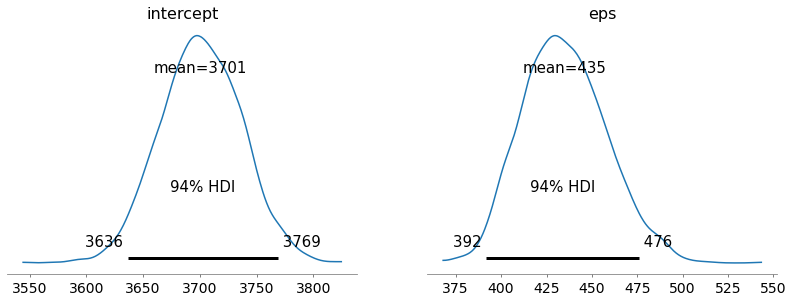

In [151]:
az.plot_posterior(idata_simple, var_names=["intercept", "eps"]);

In [150]:
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)

# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

In [19]:
with pm.Model(rng_seeder=RANDOM_SEED) as penguin_simple:
    intercept = pm.Normal("intercept", 0, 10000)
    eps = pm.HalfNormal("eps", 100)

    pm.Normal(
        "weight",
        mu=intercept,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"]
    )
    idata_simple = pm.sample()
    idata_simple.extend(pm.sample_prior_predictive())
    idata_simple.extend(pm.sample_posterior_predictive(idata_simple))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


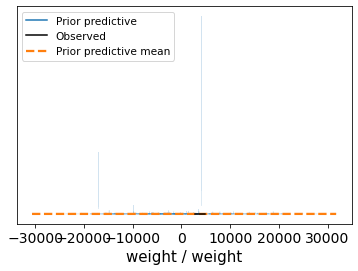

In [20]:
az.plot_ppc(idata_simple, group="prior");

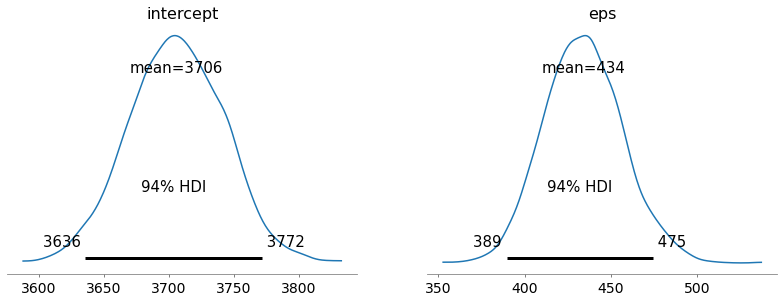

In [22]:
az.plot_posterior(idata_simple, var_names=["intercept", "eps"]);

/Users/canyon/miniconda3/envs/bayes_course/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


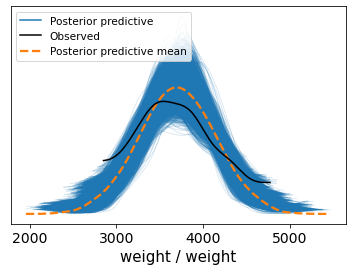

In [21]:
az.plot_ppc(idata_simple, group="posterior");

## Exercise 2: Adding Regressors


Still using the Adelie dataset perform two regressions. For each plot the posterior parameters
_hint_: In plotting the posterior the `var_names` argument is quite helpful to focus on what you plots you care about

1. Perform a regression with `bill_length_mm` only
2. Perform a regression with `bill_length_mm` and `bill_depth_mm`


In [136]:
COORDS = {
    "slopes": ["bill_length_mm"],
}

In [140]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as adelie_regression:
    
    length = pm.MutableData("bill_length_mm", adelie_penguins["bill_length_mm"].values)
    
    # priors
    intercept = pm.Normal("intercept", sigma=1000)
    β = pm.Normal("β", sigma=100, dims=("slopes"))

    
    # linear regression
    mu = (
        intercept
        + β[0] * length
    )
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"].values
    )
    idata_regression = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


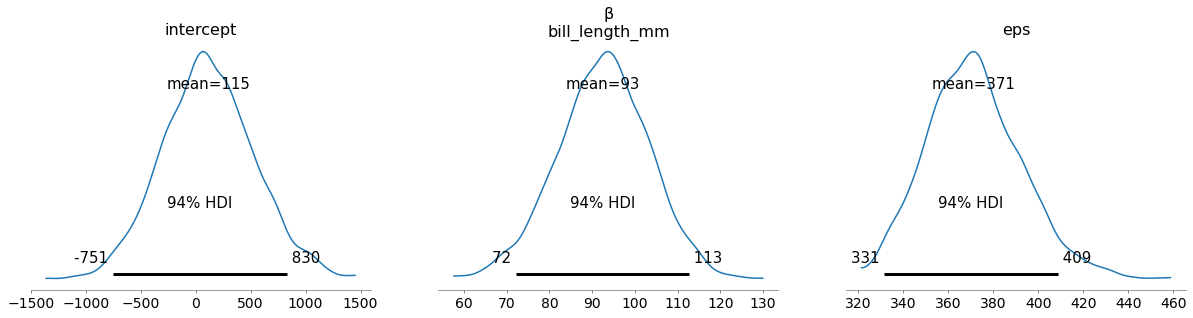

In [141]:
az.plot_posterior(idata_regression, var_names=["intercept", "β", "eps"]);

## Multiple Regression

In [142]:
COORDS = {
    "slopes": ["bill_length_mm", "bill_depth_mm"]
}

In [143]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as adelie_regression:

    # priors
    intercept = pm.Normal("intercept", sigma=100)
    β = pm.Normal("β", sigma=1000, dims=("slopes"))  

    # linear regression
    mu = (
        intercept
        + β[0] * adelie_penguins["bill_length_mm"].values
        + β[1] * adelie_penguins["bill_depth_mm"].values
    )
    
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=adelie_penguins["body_mass_g"].values
    )
    idata_regression = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


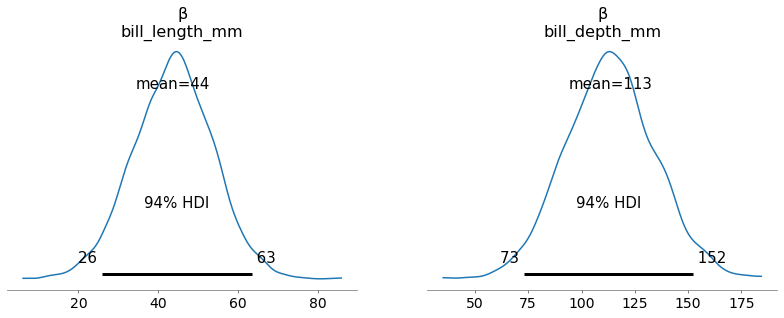

In [144]:
az.plot_posterior(idata_regression, var_names=["β"]);

## Exercise 3: Multiple Species
In this exercise we'll introduce all the species

* Expand the regression to include all penguins still using `bill_length_mm` and `bill_depth_mm` as the regressors
* Plot the posterior distribution. Verify the slopes for the Adelie penguins are the same as the previous model
  * `Hint`: the `.sel` xarray slicing will be helpful here

In [145]:
species_idx, species = penguins["species"].factorize(sort=True)

COORDS = {
    "slopes": ["bill_length_mm", "bill_depth_mm"],
    "species": species,

}

In [130]:
with pm.Model(coords=COORDS, rng_seeder=RANDOM_SEED) as penguin_regression:
    
    length = pm.MutableData("bill_length_mm", penguins["bill_length_mm"].values)
    weight = pm.MutableData("bill_depth_mm", penguins["bill_depth_mm"].values)
    species_idx_ = pm.ConstantData("species_idx", species_idx)

    
    # priors
    intercept = pm.Normal("intercept", sigma=100, dims=("species"))
    β = pm.Normal("β", sigma=1000, dims=("species", "slopes"))

    
    # linear regression
    mu = (
        intercept[species_idx_]
        + β[species_idx_, 0] * length
        + β[species_idx_, 1] * weight
    )
    # observational noise
    eps = pm.HalfNormal("eps", 100)
    
    # likelihood
    pm.Normal(
        "obs",
        mu=mu,
        sigma=eps,
        observed=penguins["body_mass_g"].values
    )
    idata_regression = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, β, eps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 61 seconds.


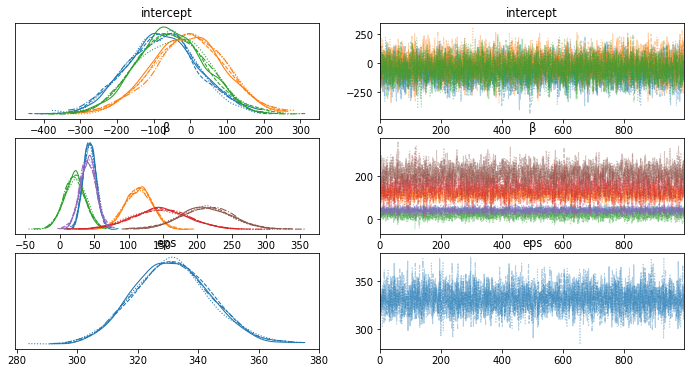

In [131]:
az.plot_trace(idata_regression);

In [132]:
idata_regression.posterior

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000, species: 3, slopes: 2)
Coordinates:
  * chain      (chain) int64 0 1 2 3
  * draw       (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * species    (species) <U9 'Adelie' 'Chinstrap' 'Gentoo'
  * slopes     (slopes) <U14 'bill_length_mm' 'bill_depth_mm'
Data variables:
    intercept  (chain, draw, species) float64 -106.0 65.92 ... -81.49 1.699
    β          (chain, draw, species, slopes) float64 46.12 112.0 ... 273.6
    eps        (chain, draw) float64 328.7 353.1 330.9 ... 341.0 347.8 317.9
Attributes:
    created_at:                 2022-03-07T02:05:14.958176
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0b2
    sampling_time:              61.15187215805054
    tuning_steps:               1000

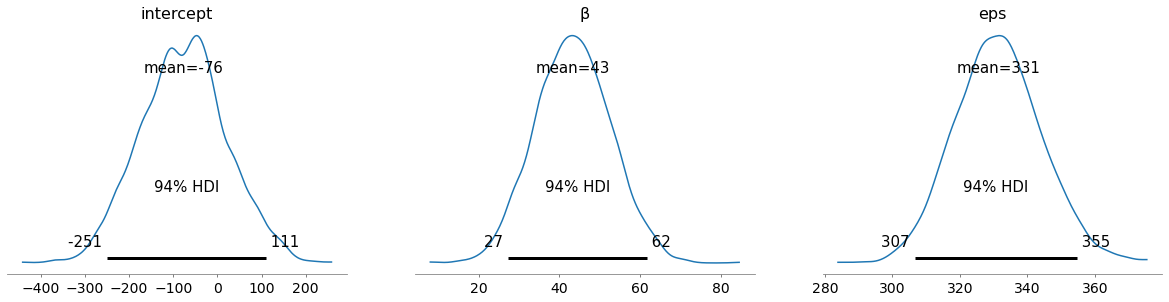

In [133]:
az.plot_posterior(idata_regression.posterior.sel(species="Adelie", slopes="bill_length_mm"));

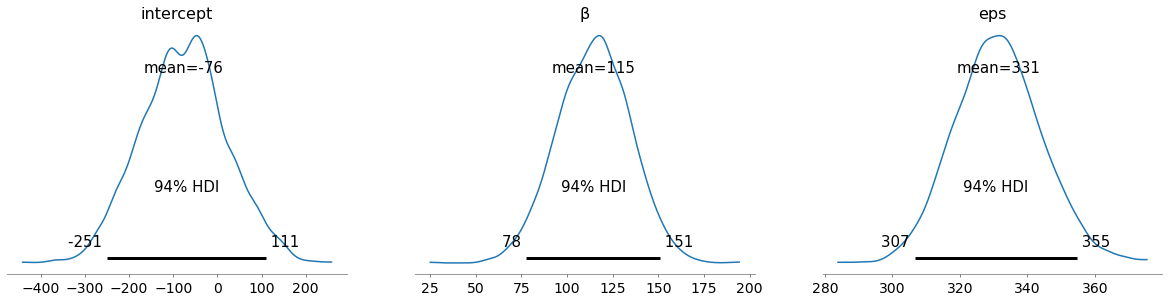

In [134]:
az.plot_posterior(idata_regression.posterior.sel(species="Adelie", slopes="bill_depth_mm"));